In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image
import tensorflow as tf
from zipfile import ZipFile
import glob
import cv2
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import joblib
from tensorflow.keras.layers import (
    Conv2D,
    Flatten,
    Dense,
    MaxPool2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    MaxPooling2D,
    Dropout,
    Activation,
)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


img_height = 224
img_width = 224
batch_size = 32

# Clear any previous session
tf.keras.backend.clear_session()

In [2]:
base = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = base + "/train"
valid_dir = base + "/valid"
diseases = os.listdir(train_dir)
diseases

['Tomato___Late_blight',
 'Tomato___healthy',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Potato___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Strawberry___Leaf_scorch',
 'Peach___healthy',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Apple___Black_rot',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Peach___Bacterial_spot',
 'Apple___Cedar_apple_rust',
 'Tomato___Target_Spot',
 'Pepper,_bell___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Strawberry___healthy',
 'Apple___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 56251 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.


In [4]:
def count_images_in_train_subfolders(train_dir: str) -> list:
    counts = []
    
    # Walk through the training directory
    for subdir, _, files in os.walk(train_dir):
        if subdir != train_dir:  # Skip the root directory
            # Count the number of image files
            image_count = len([
                file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
            ])
            # Append the count as a tuple (subfolder name, image count)
            counts.append((os.path.basename(subdir), image_count))
    
    return counts


train_directory = train_dir
train_image_counts = count_images_in_train_subfolders(train_directory)

print("Subfolder Name | Image Count")
print("-" * 30)
for subfolder, count in train_image_counts:
    print(f"{subfolder:<15} | {count}")

Subfolder Name | Image Count
------------------------------
Tomato___Late_blight | 1851
Tomato___healthy | 1926
Grape___healthy | 1692
Orange___Haunglongbing_(Citrus_greening) | 2010
Soybean___healthy | 2022
Squash___Powdery_mildew | 1736
Potato___healthy | 1824
Corn_(maize)___Northern_Leaf_Blight | 1908
Tomato___Early_blight | 1920
Tomato___Septoria_leaf_spot | 1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot | 1642
Strawberry___Leaf_scorch | 1774
Peach___healthy | 1728
Apple___Apple_scab | 2016
Tomato___Tomato_Yellow_Leaf_Curl_Virus | 1961
Tomato___Bacterial_spot | 1702
Apple___Black_rot | 1987
Blueberry___healthy | 1816
Cherry_(including_sour)___Powdery_mildew | 1683
Peach___Bacterial_spot | 1838
Apple___Cedar_apple_rust | 1760
Tomato___Target_Spot | 1827
Pepper,_bell___healthy | 1988
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) | 1722
Potato___Late_blight | 1939
Tomato___Tomato_mosaic_virus | 1790
Strawberry___healthy | 1824
Apple___healthy | 2008
Grape___Black_rot | 1888
Pota

In [5]:
def num_classes(train_dir: str) -> int:
    num_classes = 0
    
    # Count the number of subdirectories in the training directory
    for subdir in os.listdir(train_dir):
        subfolder_path = os.path.join(train_dir, subdir)
        if os.path.isdir(subfolder_path):  # Check if it's a directory
            num_classes += 1
            
    return num_classes

# Example usage
train_directory = train_dir
num_classes = num_classes(train_directory)
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 38


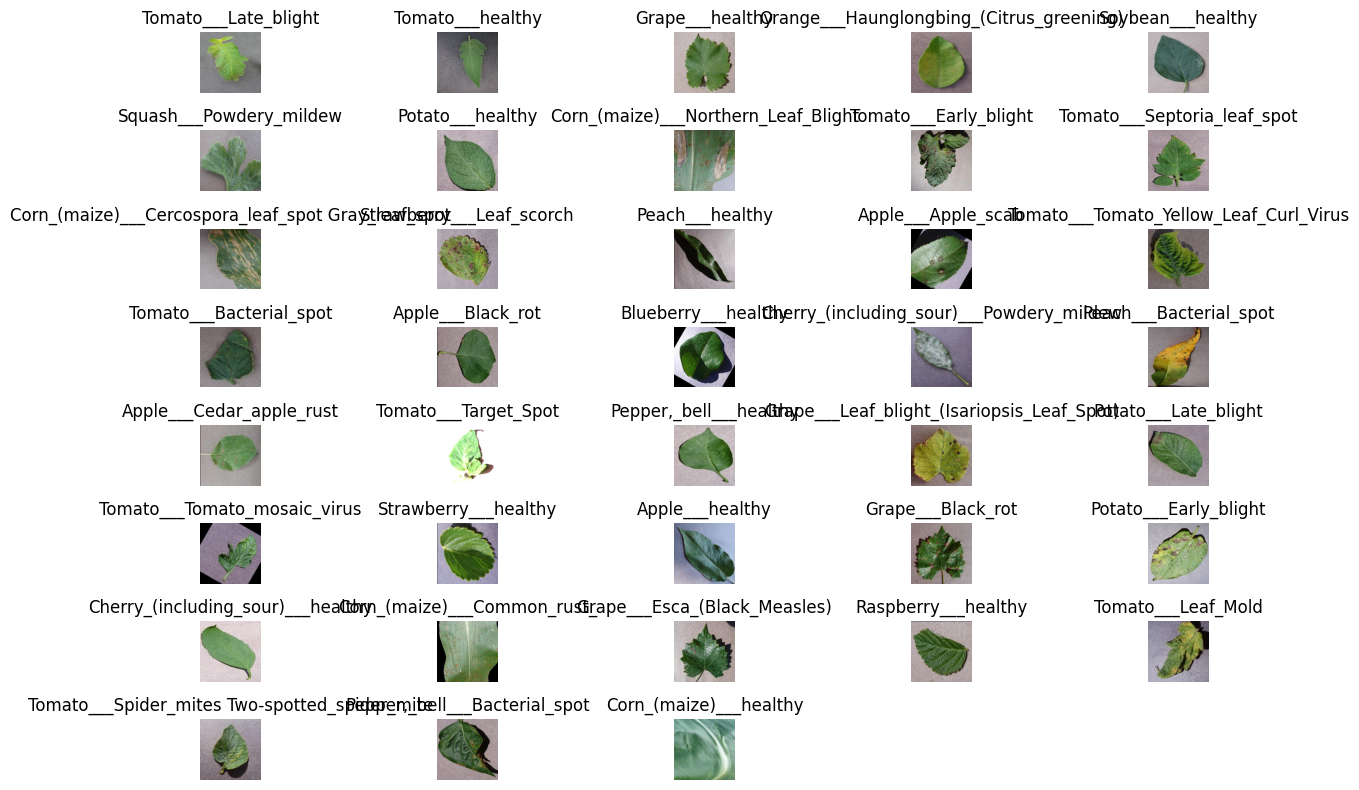

In [6]:
import matplotlib.image as mpimg
def show_class_samples(train_dir: str, num_classes: int = 38):
    class_samples = []
    
    # Get one random sample image from each class directory
    for subdir in os.listdir(train_dir):
        subfolder_path = os.path.join(train_dir, subdir)
        if os.path.isdir(subfolder_path):  # Check if it's a directory
            image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
            if image_files:  # Ensure there are images in the directory
                random_image = random.choice(image_files)  # Pick one random image
                class_samples.append((subdir, os.path.join(subfolder_path, random_image)))
    
    # Set up the subplot grid
    plt.figure(figsize=(12, 8))
    cols = 5
    rows = (num_classes + cols - 1) // cols  # Calculate rows needed

    for i, (class_name, image_path) in enumerate(class_samples):
        img = mpimg.imread(image_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

show_class_samples(train_dir)

In [7]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

# Build the CNN Model Architecture
model =  Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(),
        
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
        
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
        
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
    ])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,256,358 (84.90 MB)

 Trainable params: 22,255,398 (84.90 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    batch_size=batch_size,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730136392.190177     883 service.cc:145] XLA service 0x79c9f8009310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730136392.190250     883 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/1758 ━━━━━━━━━━━━━━━━━━━━ 1:31 52ms/step - accuracy: 0.0295 - loss: 5.1579 - precision: 0.0222 - recall: 0.0035              

I0000 00:00:1730136398.172380     883 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 185s 99ms/step - accuracy: 0.5864 - loss: 1.5341 - precision: 0.7638 - recall: 0.4535 - val_accuracy: 0.8844 - val_loss: 0.4023 - val_precision: 0.9366 - val_recall: 0.8352 - learning_rate: 1.0000e-04
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 146s 83ms/step - accuracy: 0.9004 - loss: 0.3611 - precision: 0.9437 - recall: 0.8504 - val_accuracy: 0.9238 - val_loss: 0.2597 - val_precision: 0.9515 - val_recall: 0.8945 - learning_rate: 1.0000e-04
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 152s 86ms/step - accuracy: 0.9636 - loss: 0.1448 - precision: 0.9774 - recall: 0.9459 - val_accuracy: 0.9285 - val_loss: 0.2438 - val_precision: 0.9549 - val_recall: 0.9076 - learning_rate: 1.0000e-04
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 150s 85ms/step - accuracy: 0.9842 - loss: 0.0742 - precision: 0.9891 - recall: 0.9766 - val_accuracy: 0.8989 - val_loss: 0.3414 - val_precision: 0.9246 - val_recall: 0.8805 - learning_rate: 1.0000e-04
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━━━━━

In [11]:
test_results = model.evaluate(
        test_generator,
        verbose=1
    )
test_acc = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

439/439 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.9481 - loss: 0.1939 - precision: 0.9569 - recall: 0.9432


In [13]:
train_path = '/kaggle/input/new-plant-diseases-dataset/test/test'

test_results = model.evaluate(test_generator, verbose=1)

# Extract metrics from the evaluation results
test_acc = test_results[1]  # Accuracy
test_precision = test_results[2]  # Precision
test_recall = test_results[3]  # Recall

# Print results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9422 - loss: 0.2138 - precision: 0.9528 - recall: 0.9376
Test Accuracy: 0.9448
Test Precision: 0.9542
Test Recall: 0.9406


In [15]:
# Save model
model.save("CNN_PLANT_DISEASE.h5")

In [16]:
# --ResNet 50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create our top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    batch_size=batch_size,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


I0000 00:00:1730140582.902680     882 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads



1758/1758 ━━━━━━━━━━━━━━━━━━━━ 415s 201ms/step - accuracy: 0.8308 - loss: 0.6624 - precision: 0.9124 - recall: 0.7874 - val_accuracy: 0.9777 - val_loss: 0.0703 - val_precision: 0.9800 - val_recall: 0.9756 - learning_rate: 1.0000e-04
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 309s 175ms/step - accuracy: 0.9834 - loss: 0.0540 - precision: 0.9858 - recall: 0.9811 - val_accuracy: 0.9886 - val_loss: 0.0371 - val_precision: 0.9895 - val_recall: 0.9878 - learning_rate: 1.0000e-04
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 306s 173ms/step - accuracy: 0.9867 - loss: 0.0424 - precision: 0.9882 - recall: 0.9851 - val_accuracy: 0.9722 - val_loss: 0.0879 - val_precision: 0.9744 - val_recall: 0.9696 - learning_rate: 1.0000e-04
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 307s 175ms/step - accuracy: 0.9908 - loss: 0.0311 - precision: 0.9919 - recall: 0.9897 - val_accuracy: 0.9864 - val_loss: 0.0475 - val_precision: 0.9877 - val_recall: 0.9850 - learning_rate: 1.0000e-04
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [20]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Assuming you have a list of class names from the training data
class_names = list(train_generator.class_indices.keys())  # Extract class names from train generator

# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# Save the label encoder to file
joblib.dump(label_encoder, 'label_encoder.joblib')
print("Label encoder saved as 'label_encoder.joblib'")

Label encoder saved as 'label_encoder.joblib'


In [21]:
train_path = '/kaggle/input/new-plant-diseases-dataset/test/test'

test_results = model.evaluate(test_generator, verbose=1)

# Extract metrics from the evaluation results
test_acc = test_results[1]  # Accuracy
test_precision = test_results[2]  # Precision
test_recall = test_results[3]  # Recall

# Print results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

model.save("RESNET50_PLANT_DISEASE.h5")

439/439 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9933 - loss: 0.0267 - precision: 0.9936 - recall: 0.9931
Test Accuracy: 0.9928
Test Precision: 0.9932
Test Recall: 0.9922


In [22]:
# -- VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)# Output layer

model = Model(inputs=base_model.input, outputs=predictions)# Define the full model


model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    batch_size=batch_size,
    epochs=4,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 180s 96ms/step - accuracy: 0.4626 - loss: 2.0262 - precision: 0.7715 - recall: 0.2592 - val_accuracy: 0.8639 - val_loss: 0.5110 - val_precision: 0.9438 - val_recall: 0.7693 - learning_rate: 1.0000e-04
Epoch 2/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 155s 88ms/step - accuracy: 0.8272 - loss: 0.6018 - precision: 0.9094 - recall: 0.7289 - val_accuracy: 0.9002 - val_loss: 0.3492 - val_precision: 0.9464 - val_recall: 0.8487 - learning_rate: 1.0000e-04
Epoch 3/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 156s 89ms/step - accuracy: 0.8662 - loss: 0.4332 - precision: 0.9216 - recall: 0.8107 - val_accuracy: 0.9114 - val_loss: 0.2890 - val_precision: 0.9465 - val_recall: 0.8766 - learning_rate: 1.0000e-04
Epoch 4/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 158s 90ms/step - accuracy: 0.8881 - loss: 0.3571 - precision: 0.9293 - recall: 0.8476 - val_accuracy: 0.9203 - val_loss: 0.2538 - val_precision: 0.9491 - val_recall: 0.8932 - learning_rate: 1.0000e-04


In [24]:
train_path = '/kaggle/input/new-plant-diseases-dataset/test/test'

test_results = model.evaluate(test_generator, verbose=1)

# Extract metrics from the evaluation results
test_acc = test_results[1]  # Accuracy
test_precision = test_results[2]  # Precision
test_recall = test_results[3]  # Recall

# Print results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

model.save("VGG16_PLANT_DISEASE.h5")

439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9174 - loss: 0.2799 - precision: 0.9450 - recall: 0.8877
Test Accuracy: 0.9165
Test Precision: 0.9447
Test Recall: 0.8874


In [30]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

def alexnet(input_shape=(224, 224, 3), num_classes=38):
    # Input layer
    inputs = Input(shape=input_shape)

    # AlexNet Convolutional Layers
    x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # custome layers/ top layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.0001), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

# Instantiate the model
model = alexnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

In [31]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    batch_size=batch_size,
    epochs=4,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 177s 96ms/step - accuracy: 0.3732 - loss: 2.2352 - precision: 0.6893 - recall: 0.1831 - val_accuracy: 0.6374 - val_loss: 1.2703 - val_precision: 0.7580 - val_recall: 0.5687 - learning_rate: 1.0000e-04
Epoch 2/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 151s 86ms/step - accuracy: 0.8099 - loss: 0.6338 - precision: 0.8902 - recall: 0.7275 - val_accuracy: 0.8482 - val_loss: 0.5026 - val_precision: 0.8955 - val_recall: 0.8058 - learning_rate: 1.0000e-04
Epoch 3/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 149s 84ms/step - accuracy: 0.8884 - loss: 0.3680 - precision: 0.9265 - recall: 0.8471 - val_accuracy: 0.8752 - val_loss: 0.3888 - val_precision: 0.9065 - val_recall: 0.8485 - learning_rate: 1.0000e-04
Epoch 4/4
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 145s 82ms/step - accuracy: 0.9236 - loss: 0.2449 - precision: 0.9464 - recall: 0.9029 - val_accuracy: 0.8993 - val_loss: 0.3228 - val_precision: 0.9213 - val_recall: 0.8833 - learning_rate: 1.0000e-04


In [32]:
train_path = '/kaggle/input/new-plant-diseases-dataset/test/test'

test_results = model.evaluate(test_generator, verbose=1)

# Extract metrics from the evaluation results
test_acc = test_results[1]  # Accuracy
test_precision = test_results[2]  # Precision
test_recall = test_results[3]  # Recall

# Print results
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

model.save("VGG16_PLANT_DISEASE.h5")

439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.8827 - loss: 0.3883 - precision: 0.9086 - recall: 0.8682
Test Accuracy: 0.8889
Test Precision: 0.9136
Test Recall: 0.8735


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


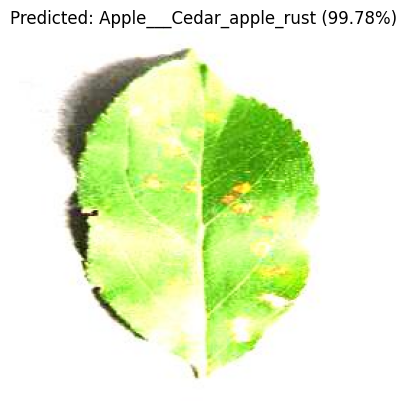

('Apple___Cedar_apple_rust', 99.77744221687317)

In [27]:
from tensorflow.keras.preprocessing import image

# An Unseen data of an "Apple Cedar Rust Image" to predict the label of it
img_path = "/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG"
label_encoder = joblib.load('label_encoder.joblib')

def evaluate_single_image(model, img_path, target_size=(224, 224)):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize as per model training

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100

    # Decode the class index to the class label
    predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

    # Display the image with predicted class
    plt.imshow(image.load_img(img_path))  # Display the image
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence


evaluate_single_image(model, img_path)

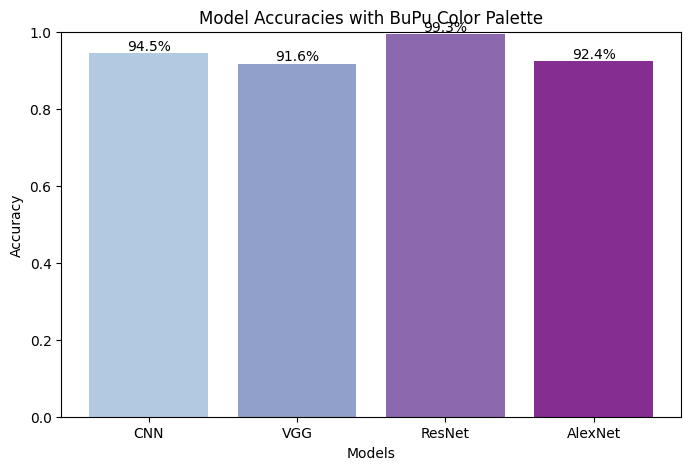

In [34]:
# Model names and accuracies
models = ['CNN', 'VGG', 'ResNet', 'AlexNet']
accuracies = [0.9448, 0.9165, 0.9928, 0.9236]

# Create a BuPu color palette
colors = plt.cm.BuPu(np.linspace(0.3, 0.8, len(models)))  # Adjust range for color intensity

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors)

# Add percentage labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1%}', ha='center', va='bottom')

# Add title and labels
plt.title('Model Accuracies with BuPu Color Palette')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Show the plot
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage display
plt.show()